In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from joblib import Parallel, delayed

from baseline.data import MoleculeDatapoint, MoleculeDataset, filter_features
from baseline.splits import split_data
from baseline.utils import make_rdkit_mol
from baseline.featurizers import MorganFeaturizer, MordredFeaturizer

/tmp/ipykernel_633815/2384319032.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
path = "/home/hwpang/Projects/BaselineML/data/biogen_solubility.csv"
data_df = pd.read_csv(path)

In [3]:
data_df["mol"] = data_df["SMILES"].apply(make_rdkit_mol)

In [7]:
datapoints = [
    MoleculeDatapoint(
        mol,
        solubility,
        featurizer=MorganFeaturizer(),
    )
    for mol, solubility in zip(data_df["mol"], data_df["logS"])
]

In [8]:
train_dpoints, _, test_dpoints = split_data(datapoints, split_sizes=(0.9, 0.0, 0.1))

In [9]:
train_dset = MoleculeDataset(train_dpoints)
test_dset = MoleculeDataset(test_dpoints)

pca = train_dset.reduce_features(n_components=0.8)
test_dset.reduce_features(pca)

label_scaler = train_dset.normalize_labels()
test_dset.normalize_labels(label_scaler)


StandardScaler()

In [10]:
X_train = train_dset.features.numpy()
y_train = train_dset.labels.numpy()
beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

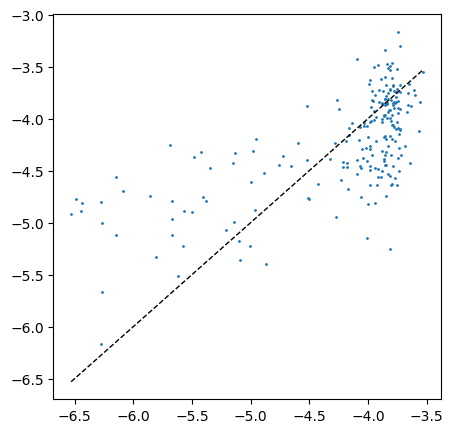

In [11]:
y_test_pred = test_dset.features @ beta
y_test_pred = label_scaler.inverse_transform(y_test_pred)
y_test = test_dset.labels
y_test = label_scaler.inverse_transform(y_test)
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_test_pred, s=1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "k--", lw=1)